# Project overview

The aim of the project is to extract skills entities from job postings provided by indeed.com. 

## Challenges

First of all there are challenges presented in this topic. The first one is the general difficulities in dealing with unstructured textual data, with the inconsistent format of job postings that varies from origanisations to origanisations. Although most job postings would have Jobs Requirement section, it is also possible that additional desirable skills are appearing in other sections of the job posting, e.g. What to Expect. In addition, fancy formatting would also cause problems.

The second challenge would be the word ambiguity. There are many ambiguities in phrases used in job postings and it varies from field to field. Specifically, some skills can be presented in different ways, e.g. C++ and CPP, C# and C Sharp, which contributes to another challenge of duplication and would be a major obstacle when analyzing the transforming trend of digitisation and how new skill requirements evolve against time. In contrast, there are also the same terms expressing different skills under different contexts (word sense ambiguity). For example, the term organ can be the surgery experience of a doctor but can also mean the instrument that a musician can play, and ZooKeepers can mean Apache Zookeepers as well as actual keeps for a Zoo. To make things more complicated, it can also appear in the resume of a physician that performed an organ surgery but also plays the organ. The third type of ambiguity would be acronyms. For example, BI can be short for Bank Indonesia and also for Business Intelligence, which leads to the fourth type of ambiguity – skills being overlapped with other known entities.

The third major challenge would be duplication. There is one type that is already mentioned in the earlier paragraph – multiple expressions for the same skill. A more common type of duplication would be typos and different ways of writing according to different companies, and also acronyms for skills. For example, companies may use OOP to refer to object-oriented programming. This challenge would need major attention in improving the performance of the project as having duplication affects strongly on the trend analysis.

## Approaches

The earliest work can be traced back to 1988 (Salton1988), where the author investigated approaches to automatically weight terms to retrieve texts. While more recent works have combined machine learning and Natural Language Processing and word embedding techniques to perform more accurate systems to identify, ex- tract and normalize skill entities from different unstructured input sources like job postings. Existing approaches include the following:

1) skill extraction from text documents by generating the semantic similarity between input text and Wikipedia and then returns a list of skills from a list of Wikipedia links using biased Spreading Activation algorithm.

2) a large-scale topic extraction pipeline that was applied to LinkedIn in the ‘Skills and Expertise’ section, where the paper then worked on im- plementing the recommendation system according to the extracted and normalized skills. The author used clustering technique for word sense disambiguation.

3) identifies and normalizes skill entities from job postings and resumes with ensembles of different embedding models. API calls to wikipedia is then used to strength word sense disambiguation

3) 1) a following work has been focues on a newly implemented system for Word Sense Disambiguation that assign the most appropriate skill sense to multi-sense skill entity concerning a given context.   

4) a system that extracts and classifies occupations and skills using pre-defined and constantly expanding skill-occupation ontology, with an esamble of multible word embedding models including word2vec, doc2vec and FastText.

5) a newer work included an ensemble of different approaches including NER, PoS and dictionaru extraction for more accurate extractions.


## Workflow

In this notebook we will walk through the pipeline of skills-ml. The workflow of the pipeline is as following:

1) the job posting data is pre-processed to generate text corpus for training etc. 

2) followed by embedding into vector space. 

3) Then the matching between the result of the earlier stage with pre-defined ontology is carried out and the result can be iteratively fed into the system to enrich the ontology. 

4) Together with the skill phrase, the surrounding text is also fetched for disambiguation purposes, while the detailed approaches are not addressed in the article.

# House-keeping

In deploying existing libraries, it is often painful to encounter dependency conflicts in between libraries as well as missing packaged in the master library.

In this case, although the documentation of skills-ml demonstrates instialling through the command 'pip install skills-ml' it does not effectly work as some dependencies and functions are missing and the version is not updated. Alternative solutions would be installing through git, which works for this one.

In [1]:
from skills_ml.ontologies.onet import Onet

from skills_ml.job_postings.raw.virginia import VirginiaTransformer
from typing import Dict, Text, Any, Generator
import json

import pandas as pd

from skills_ml.algorithms.embedding.models import visualize_in_tensorboard

from skills_ml.algorithms.skill_extractors import SkillEndingPatternExtractor
from skills_ml.job_postings.common_schema import JobPostingCollectionSample
from skills_ml.algorithms.skill_extractors import ExactMatchSkillExtractor
from skills_ml.algorithms.skill_extractors import SocScopedExactMatchSkillExtractor

from skills_ml.ontologies import Competency
from skills_ml.ontologies.viz import display_nodes
from skills_ml.ontologies import Occupation
from skills_ml.ontologies import CompetencyOntology
from skills_ml.ontologies.viz import display_ontology

from skills_ml.ontologies.onet import Onet

from skills_ml.ontologies.onet import majorgroupname
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style="darkgrid", font_scale=2)
%matplotlib inline

from skills_ml.job_postings.filtering import JobPostingFilterer
from skills_ml.job_postings.sample import JobSampler

from skills_ml.algorithms.embedding.models import Word2VecModel, FastTextModel
from skills_ml.algorithms.preprocessing import IterablePipeline
from skills_ml.algorithms import nlp
from functools import partial
from skills_ml.job_postings.corpora import Word2VecGensimCorpusCreator, Doc2VecGensimCorpusCreator
from skills_ml.algorithms.embedding.train import EmbeddingTrainer
from skills_ml.storage import FSStore, S3Store, ModelStorage

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Building ontology sample to visualise

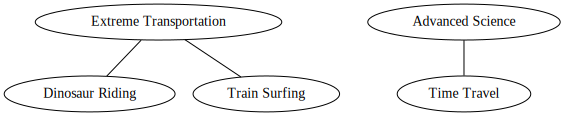

In [2]:
# import ontologies with some predefined skills

dinosaur_riding = Competency(
    identifier='dino_riding',
    name='Dinosaur Riding',
    description='Using the back of a dinosaur for transportation'
)

dinosaur_riding = Competency(
    identifier='12345',
    name='Dinosaur Riding',
    description='Using the back of a dinosaur for transportation'
)

train_surfing = Competency(
    identifier='12346',
    name='Train Surfing',
    description='Standing on the train while it goes'
)

time_travel = Competency(
    identifier='23456',
    name='Time Travel',
    description='Traveling Through Time'
)

advanced_science = Competency(
    identifier='2345',
    name='Advanced Science',
)

extreme_transportation = Competency(
    identifier='123',
    name='Extreme Transportation',
    description='Comically dangerous forms of transportation'
)

time_travel.add_parent(advanced_science)
dinosaur_riding.add_parent(extreme_transportation)
train_surfing.add_parent(extreme_transportation)
display_nodes([dinosaur_riding, train_surfing, extreme_transportation, time_travel, advanced_science])

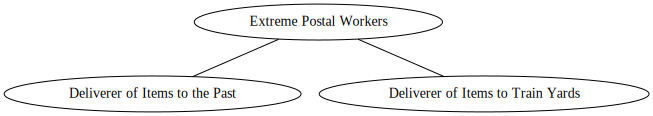

In [3]:
extreme_postal_workers = Occupation(identifier='999', name='Extreme Postal Workers')
dino_postal_worker = Occupation(identifier='9998', name='Deliverer of Items to the Past')
train_yard_postal_worker = Occupation(identifier='9999', name='Deliverer of Items to Train Yards')
dino_postal_worker.add_parent(extreme_postal_workers)
train_yard_postal_worker.add_parent(extreme_postal_workers)

display_nodes([extreme_postal_workers, dino_postal_worker, train_yard_postal_worker])

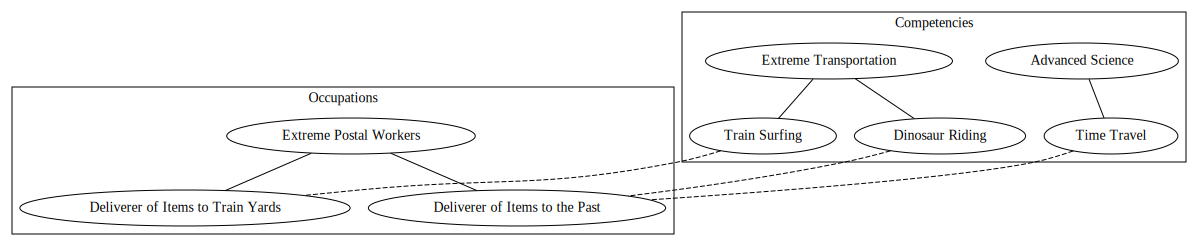

In [4]:
ontology = CompetencyOntology()
ontology.add_competency(dinosaur_riding)
ontology.add_competency(train_surfing)
ontology.add_competency(extreme_transportation)
ontology.add_competency(time_travel)
ontology.add_competency(advanced_science)

ontology.add_occupation(dino_postal_worker)
ontology.add_occupation(train_yard_postal_worker)
ontology.add_occupation(extreme_postal_workers)

ontology.add_edge(occupation=dino_postal_worker, competency=dinosaur_riding)
ontology.add_edge(occupation=dino_postal_worker, competency=time_travel)
ontology.add_edge(occupation=train_yard_postal_worker, competency=train_surfing)

display_ontology(ontology)

# Prebuilt Ontologies

In [6]:
onet = Onet()
onet.print_summary_stats()

2020-07-08 07:16:02,022 : INFO : Manual build specified. Building O*NET CompetencyOntology via direct querying from O*NET site, or local cache.
2020-07-08 07:16:02,024 : INFO : Processing Content Model Reference
2020-07-08 07:16:03,843 : INFO : Processing occupation data
2020-07-08 07:16:05,270 : INFO : Processing Knowledge, Skills, Abilities
2020-07-08 07:16:42,627 : INFO : Processing tools and technology


Ontology summary statistics for onet
Num competencies: 32030
Num occupations: 1133
Num competency-occupation edges: 107305
Median occupations per competency: 1
Median competencies per occupation: 89
Mean occupations per competency: 3.350245090386837
Mean competencies per occupation: 94.70873786407768


In [7]:
display_nodes(onet.occupations)

In [8]:
list(onet.competencies)[0:5]

[Competency(identifier=60121305-Fabric cutters, name=Fabric cutters, categories=['Tools', 'O*NET T2'], {}),
 Competency(identifier=48101611-Weigh hoppers, name=Weigh hoppers, categories=['Tools', 'O*NET T2'], {}),
 Competency(identifier=22101529, name=Skid steer loaders, categories=['Tools', 'UNSPSC Commodity'], {}),
 Competency(identifier=25111508, name=Passenger or automobile ferries, categories=['Tools', 'UNSPSC Commodity'], {}),
 Competency(identifier=42201704-Bone ultrasound densitometers, name=Bone ultrasound densitometers, categories=['Tools', 'O*NET T2'], {})]

# Filtering

In [9]:
nurse_practitioners = onet.filter_by(lambda edge: 'Nurse Practitioners' in edge.occupation.name)
print(list(nurse_practitioners.competencies)[0:5])
print('-' * 50)
# inspect categories
print(set(cat for competency in nurse_practitioners.competencies for cat in competency.categories))

[Competency(identifier=1.A.1.d.1, name=Memorization, categories=['Abilities'], {'competencyText': 'The ability to remember information such as words, numbers, pictures, and procedures.'}), Competency(identifier=42142532-Pericardiocentesis kits, name=Pericardiocentesis kits, categories=['Tools', 'O*NET T2'], {}), Competency(identifier=43211509-Tablet computers, name=Tablet computers, categories=['Tools', 'O*NET T2'], {}), Competency(identifier=42182412-Diagnostic tuning forks, name=Diagnostic tuning forks, categories=['Tools', 'O*NET T2'], {}), Competency(identifier=2.A.1.f, name=Science, categories=['Skills'], {'competencyText': 'Using scientific rules and methods to solve problems.'})]
--------------------------------------------------
{'Knowledge', 'Tools', 'O*NET T2', 'Abilities', 'Skills', 'Technology'}


# Data conversion into common schema

In the documentmentation, unforturnately the API for database is down and we have no access to the data the author used. However we could always adapt our data to their format.

In [10]:
# load data scraped from indeed.com
file_name = '../data/sample_full.csv' 
df = pd.read_csv(file_name, index_col=0).reset_index(drop=True)
df.head()

,location,company_name,job_title,summary,full_info
0,London,Lewisham Council,Finance and Admin Officer,Job type: full-time 35 hours.\nTo provide Fina...,Job Ref: RES-20-003\nJob type: full-time 35 ho...
1,London,"UK Government - Department for Business, Energ...",International Climate Finance Communications a...,This will entail effectively responding to bri...,Communications is an increasingly significant ...
2,London,Nucleus Central,Assistant Finance Project Analyst,"Working within the Finance department, you wil...",Nucleus Global is comprised of the medical com...
3,London,BNP Paribas,London - Graduate Analyst Programme 2020 - Tra...,The Group helps them realise their personal an...,WHO WE ARE\nThe bank for a changing world. BNP...
4,London,Harrington-Leigh,Trainee Mortgage & Protection Advisor - REMOTE...,We are looking to take on Individuals with no ...,Trainee Mortgage & Protection Advisor Main tas...


In [11]:
fname = '../data/50_sample.json'
f = open(fname, 'r')
data = f.read().split('\n')[0]

json_data = json.loads(data)

print('job posting schema sample')
print(json_data)

job posting schema sample
{'positionPeriod': {'startDate': '', 'endDate': ''}, 'veteranCommitment': '', 'datePosted': '2016-03-17', 'hiringOrganization': {'organizationName': '1105 Media, Inc.', 'organizationTaxID': '', 'url': '', 'organizationCode': '51', 'organizationUnit': '', 'additionalName': [], 'location': '', 'organizationDescription': '', 'logo': '', 'geo': {'latitude': None, 'longitude': None}}, 'id': 'b8b7cc64d082dda5165419fbd3c483cc', 'salaryCurrency': '', 'title': 'Media Consultant', 'employmentType': [], 'responsibilities': ['Drive advertising revenue with aggressive sales efforts that penetrate new markets and increase existing market presence', 'Consult with customers to be able to properly articulate the value proposition of a product package that exceeds customer goals and aligns with the business direction.', 'Build customer relationships on an ongoing basis', 'Accelerate growing online business through vast knowledge of digital products, deliverables and metrics', '

In [12]:
d = json_data.copy()
for key, val in d.items():
    print(key)
    if isinstance(val, dict):
        for subkey, subval in d[key].items():
            print('\t' + str(subkey))

positionPeriod
	startDate
	endDate
veteranCommitment
datePosted
hiringOrganization
	organizationName
	organizationTaxID
	url
	organizationCode
	organizationUnit
	additionalName
	location
	organizationDescription
	logo
	geo
id
salaryCurrency
title
employmentType
responsibilities
normalizedTitle
	onetName
	onetCode
numberOfOpenings
occupationalCategory
incentiveCompensation
specialCommitments
jobBenefits
qualifications
baseSalary
	salary
	maxSalary
	minSalary
	medianSalary
dateExpires
workHours
experienceRequirements
url
skills
jobDescription
jobLocation
	geo
	address
educationRequirements


In [13]:
# now we just fill our data into this schema
# note that although many of the import entries are missing in our data (soc)
# it is still a good start point

df_small = df.iloc[0:100, :].copy()

df_json = []
for i in range(df_small.shape[0]):
    df_json.append(json_data.copy())
    df_json[i]['hiringOrganization']['location'] = df_small['location'][i]
    df_json[i]['hiringOrganization']['organizationName'] = df_small['company_name'][i]
    df_json[i]['title'] = df_small['job_title'][i]
    df_json[i]['jobDescription'] = df_small['full_info'][i].split('\n')
    df_json[i]['responsibilities'] = df_small['summary'][i].split('\n')
    
# save for later use    
# with open("../data/indeed_schema.json", "w") as write_file:
#     for i in df_json:
#         json.dump(i, write_file)
#         write_file.write('\n')

In [14]:

## reads json data file

JobPostingType = Dict[Text, Any]
JobPostingGeneratorType = Generator[JobPostingType, None, None]
MetadataType = Dict[Text, Dict[Text, Any]]

class JobPostingParserIndeed(object):
    def __init__(self):
        fname = '../data/indeed_schema.json'
        f = open(fname, 'r')
        self.lines = f.read().split('\n')
        self.transformer = VirginiaTransformer(partner_id = 'VA')
        
    def __iter__(self) -> JobPostingGeneratorType:
        for line in self.lines:
            if line:
                yield self.transformer._transform(json.loads(line))
                
class JobPostingParser(object):
    def __init__(self, num_records:int=50):
        if num_records > 50:
            logging.warning('Cannot provide %s records as a maximum of 50 are available', num_records)
            num_records = 50
        fname = '../data/50_sample.json'
        f = open(fname, 'r')
#         self.lines = f.read().decode('utf-8').split('\n')[0:num_records]
        self.lines = f.read().split('\n')[0:num_records]
        self.transformer = VirginiaTransformer(partner_id = 'VA')
        
    def __iter__(self) -> JobPostingGeneratorType:
        for line in self.lines:
            if line:
                yield self.transformer._transform(json.loads(line))

job_postings = JobPostingParser()

In [15]:
indeed_job_postings = JobPostingParserIndeed()
# sample_job_postings = JobPostingParserSample()

In [16]:
for job_posting in indeed_job_postings:
    print(job_posting['title'])

WORKING FROM HOME - Trainee Financial Broker
Accounts Assistant
Finance Administrative Assistant - Part Time
London Based Finance assetmanagement fund Sales Intern
Finance Assistant
Investment Banking, Summer Associate, London (Europe, Middle East and Africa)
Finance Trainee
Junior Finance Analyst
Accounts Payable Assistant - Finance
Junior Analyst
Facilities Management/Finance Admin Coordinator
WORKING FROM HOME - Trainee Financial Broker
Junior Analyst
Admin and Finance Officer
Junior Finance Analyst
Finance Assistant
Finance Officer
Financial Analyst
Global Graduate Finance
Private Equity Analyst
WORKING FROM HOME - Trainee Financial Broker
General Ledger Specialist
Intelligence Analyst
Finance Administrative Assistant - Part Time
Retail Finance Analyst
Assistant Financial Accountant
Corporate Finance Associate
Account Onboarding Intern / Analyst
Private Equity Analyst
Accounts Assistant
WORKING FROM HOME - Trainee Financial Broker
General Ledger Specialist
Intelligence Analyst
Acco

In [17]:
for job_posting in job_postings:
    print(job_posting['title'])

Media Consultant
Social Media Intern
Automotive Service Manager-Norfolk Car Care Center
Automotive Service Manager-Hampton Car Care Center
Service Truck Operator-Norfolk
Automotive Technician-Chesapeake
Lube Technician-Norfolk
Automotive Technician-Williamsburg
Insurance Agent
Automotive Technician-Suffolk
State Inspector- Chesapeake
State Inspector- Suffolk
State Inspector- Virginia Beach
Automotive Service Manager-Chesapeake Car Care Center
Supply Specialist (SCA)
Site Support Lead
Supply Specialist (SCA)
Drafter
Supervisor / Lead Testers
Product Group Unit Controller
Electrical Design Engineer
Supply Chain Manager
Alliance Marketing Manager
Sales Manager - North America Rail and Traction
Driver Training School - City Driver
Operations Assistant
City Driver Full-Time Combined Dock/P&D
Operations Supervisor
Dock Worker Part-Time
City Driver Full-Time Combined Dock/P&D
Dock Worker Part-Time
City Driver Part-Time Combined Dock/P&D
Account Manager
City Driver Part-Time Combined Dock/P&D


# Visualisation

Computer and Mathematical       6
Architecture and Engineering    6
dtype: int64

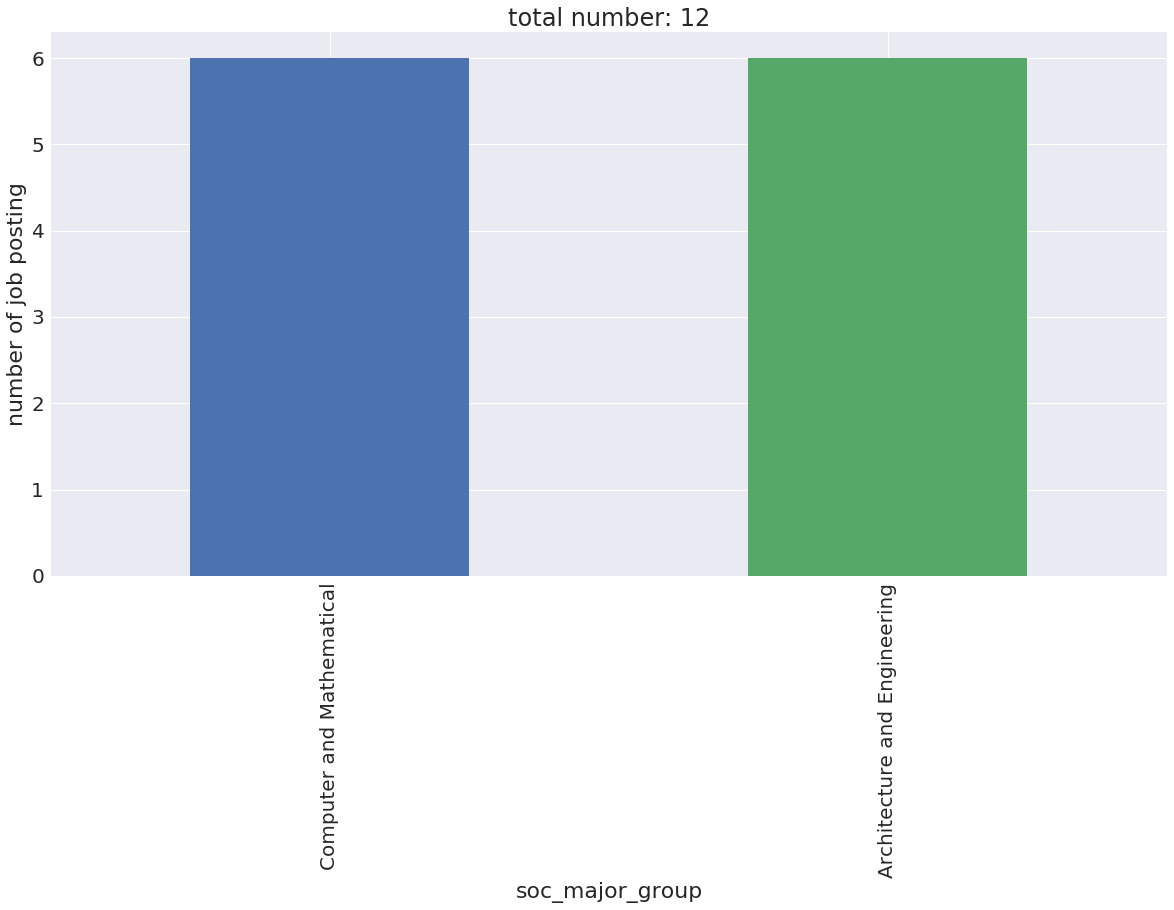

In [18]:
def is_tech_jobs(job):
    if job['onet_soc_code'][:2] in ['15', '17', '19']:
        return True
    else:
        return False
    
tech_jobs = JobPostingFilterer(
    job_posting_generator=JobPostingParser(), 
    filter_funcs=[is_tech_jobs]
)

# major group distribution plotting function

def plot_major_group_distribution(job_postings):
    c = Counter()
    for job in job_postings:
        c.update([job['onet_soc_code'][:2]])
    s = pd.Series(c).sort_index()
    s.index = s.index.map(majorgroupname)
    ax = s.plot.bar(figsize=(20,10),rot=90)
    ax.set_xlabel('soc_major_group')
    ax.set_ylabel('number of job posting')
    ax.set_title(f"total number: {s.sum()}")
    return s

plot_major_group_distribution(tech_jobs)

Management                                         8
Business and Financial Operations                  3
Computer and Mathematical                          6
Architecture and Engineering                       6
Arts, Design, Entertainment, Sports, and Media     2
Healthcare Practitioners and Technical             2
Sales and Related                                  1
Office and Administrative Support                  3
Installation, Maintenance, and Repair              2
Transportation and Material Moving                12
dtype: int64

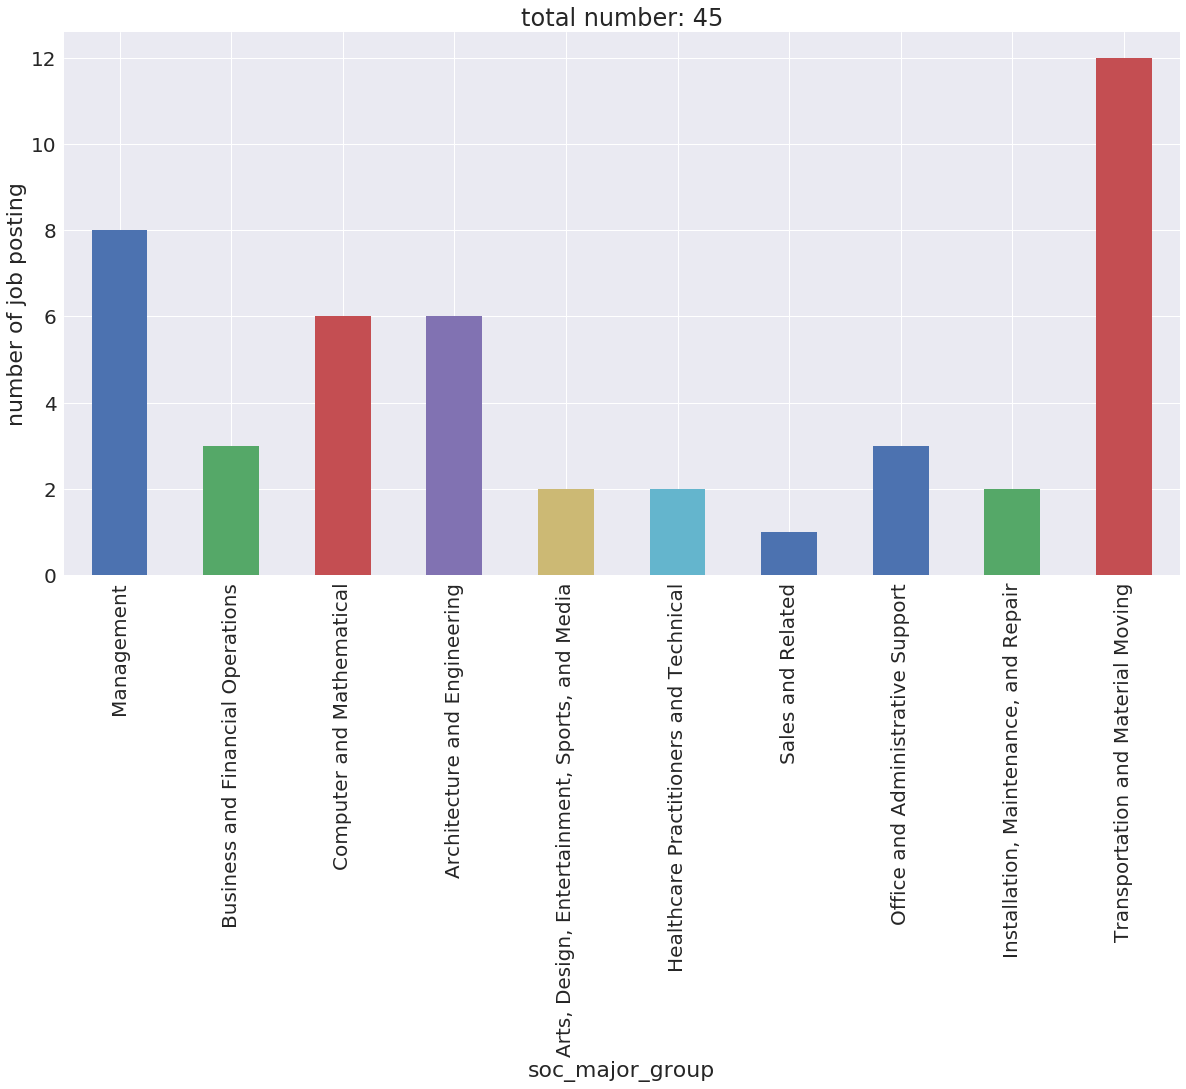

In [19]:
def filter_onet_soc_code(job):
    if job['onet_soc_code'] and job['onet_soc_code'][:2] != '99':
        return True
    else:
        return False

has_soc = lambda x: x['onet_soc_code']
not_unknown_soc = lambda x: x['onet_soc_code'][:2] != '99'

jobpostings_filtered = JobPostingFilterer(
    job_posting_generator=JobPostingParser(), 
    filter_funcs=[has_soc, not_unknown_soc]
)

plot_major_group_distribution(jobpostings_filtered)

# Skill Extraction

In [20]:
# Skill extraction

## using pattern
job_posting_generator = JobPostingParserIndeed()
# instantiate the skill extractor. This class defaults to only considering lines that
# start with a bullet, which doesn't work for this dataset. So we set this flag to False.
skill_extractor = SkillEndingPatternExtractor(only_bulleted_lines=False)
job_posting = next(iter(job_posting_generator))
print('using pattern')
print('-' * 50)
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')
print('-'*50)

## exact match
skill_extractor = ExactMatchSkillExtractor(onet.competency_framework)
print('exact match')
print('-' * 50)
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')
print('-'*50)
    
## SocScopedExactMatch
skill_extractor = SocScopedExactMatchSkillExtractor(onet)
print('SocScopedExactMatch')
print('-' * 50)
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')
print('-'*50)

2020-07-08 07:24:21,835 : INFO : Yielding candidate skill communication skills in context College degree preferred, 2 - 5 years experience in print and / or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self - motivated, team - oriented, and customer - centric, Understanding of how to research potential customers and use online analytics from a sales perspective, Weekly local travel to meet with clients / prospects is required, Minimal non local travel a few times a year is required
2020-07-08 07:24:21,839 : INFO : Yielding candidate skill organizational skills in contex

using pattern
--------------------------------------------------
skill name: communication skills
context: College degree preferred, 2 - 5 years experience in print and / or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self - motivated, team - oriented, and customer - centric, Understanding of how to research potential customers and use online analytics from a sales perspective, Weekly local travel to meet with clients / prospects is required, Minimal non local travel a few times a year is required

skill name: organizational skills
context: College degree preferred, 2 

2020-07-08 07:24:26,116 : INFO : Yielding exact match <_sre.SRE_Match object; span=(283, 289), match='levels'> in string As part of personal development the role holder will gain practical experience in the Financial Planning and Analysis and Finance Business Partner teams., , , The Candidate:, Appreciation of the needs of internal and external stakeholders., Ability to communicate effectively at all levels., Ability to report accurately and meet deadlines., Able to identify issues and help develop solutions., Demonstrates a strong work ethic and maintains very high standards with high levels of attention to detail., IT literate with high level of proficiency in Microsoft Excel., Desire to study towards completing accounting qualification., Enthusiastic team player with emotional intellect to develop effective networks and drive change.
2020-07-08 07:24:26,117 : INFO : Yielding exact match <_sre.SRE_Match object; span=(472, 478), match='levels'> in string As part of personal developmen

exact match
--------------------------------------------------
skill name: levels
context: As part of personal development the role holder will gain practical experience in the Financial Planning and Analysis and Finance Business Partner teams., , , The Candidate:, Appreciation of the needs of internal and external stakeholders., Ability to communicate effectively at all levels., Ability to report accurately and meet deadlines., Able to identify issues and help develop solutions., Demonstrates a strong work ethic and maintains very high standards with high levels of attention to detail., IT literate with high level of proficiency in Microsoft Excel., Desire to study towards completing accounting qualification., Enthusiastic team player with emotional intellect to develop effective networks and drive change.

skill name: levels
context: As part of personal development the role holder will gain practical experience in the Financial Planning and Analysis and Finance Business Partner teams

2020-07-08 07:24:27,738 : INFO : Found 96 entries for lookup
2020-07-08 07:24:27,756 : INFO : Yielding exact match <_sre.SRE_Match object; span=(550, 565), match='Microsoft Excel'> in string As part of personal development the role holder will gain practical experience in the Financial Planning and Analysis and Finance Business Partner teams., , , The Candidate:, Appreciation of the needs of internal and external stakeholders., Ability to communicate effectively at all levels., Ability to report accurately and meet deadlines., Able to identify issues and help develop solutions., Demonstrates a strong work ethic and maintains very high standards with high levels of attention to detail., IT literate with high level of proficiency in Microsoft Excel., Desire to study towards completing accounting qualification., Enthusiastic team player with emotional intellect to develop effective networks and drive change.


SocScopedExactMatch
--------------------------------------------------
skill name: microsoft excel
context: As part of personal development the role holder will gain practical experience in the Financial Planning and Analysis and Finance Business Partner teams., , , The Candidate:, Appreciation of the needs of internal and external stakeholders., Ability to communicate effectively at all levels., Ability to report accurately and meet deadlines., Able to identify issues and help develop solutions., Demonstrates a strong work ethic and maintains very high standards with high levels of attention to detail., IT literate with high level of proficiency in Microsoft Excel., Desire to study towards completing accounting qualification., Enthusiastic team player with emotional intellect to develop effective networks and drive change.

--------------------------------------------------


In [21]:
## pattern matching for more postings
for job_posting in job_postings:
    # print('using pattern')
    for candidate_skill in skill_extractor.candidate_skills(job_posting):
        print('skill name:', candidate_skill.skill_name)
        print('context:', candidate_skill.context)
        print('')
    print('-'*50)

2020-07-08 07:24:43,823 : INFO : Found 123 entries for lookup
2020-07-08 07:24:43,848 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.
2020-07-08 07:24:43,852 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.


--------------------------------------------------
--------------------------------------------------
skill name: time management
context: Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.

--------------------------------------------------
skill name: time management
context: Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.

--------------------------------------------------


2020-07-08 07:24:44,076 : INFO : Found 247 entries for lookup
2020-07-08 07:24:44,117 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.must be able to deal with negative emotions from others, displaying a positive, caring attitude on each interaction.


--------------------------------------------------
--------------------------------------------------
skill name: time management
context: Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.must be able to deal with negative emotions from others, displaying a positive, caring attitude on each interaction.

--------------------------------------------------


2020-07-08 07:24:44,221 : INFO : Found 101 entries for lookup
2020-07-08 07:24:44,328 : INFO : Found 107 entries for lookup
2020-07-08 07:24:44,351 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 16), match='Active listening'> in string Active listening-- listening to, interpreting, understanding, and processing verbal information; probing to ensure all key information is obtained from member.
2020-07-08 07:24:44,352 : INFO : Yielding exact match <_sre.SRE_Match object; span=(74, 82), match='speaking'> in string Communication and telephone skills-- using proper telephone etiquette and speaking in a clear, understandable manner; tactfully controlling interactions in order to efficiently obtain and give necessary information; clearly explaining itineraries, costs, and other travel related information; preparing written communications and documents.


--------------------------------------------------
skill name: active listening
context: Active listening-- listening to, interpreting, understanding, and processing verbal information; probing to ensure all key information is obtained from member.

skill name: speaking
context: Communication and telephone skills-- using proper telephone etiquette and speaking in a clear, understandable manner; tactfully controlling interactions in order to efficiently obtain and give necessary information; clearly explaining itineraries, costs, and other travel related information; preparing written communications and documents.

--------------------------------------------------
--------------------------------------------------


2020-07-08 07:24:44,467 : INFO : Found 163 entries for lookup
2020-07-08 07:24:44,501 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.
2020-07-08 07:24:44,505 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.
2020-07-08 07:24:44,508 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.
2020-07-08 07:24:44,618 : INFO : Found 220 entries for lookup


skill name: time management
context: Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.

--------------------------------------------------
skill name: time management
context: Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.

--------------------------------------------------
skill name: time management
context: Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------


2020-07-08 07:24:44,746 : INFO : Found 180 entries for lookup
2020-07-08 07:24:44,776 : INFO : Yielding exact match <_sre.SRE_Match object; span=(50, 57), match='writing'> in string Essential duties and responsibilities: Reports in writing and orally to AAR DSL management.
2020-07-08 07:24:44,878 : INFO : Found 108 entries for lookup
2020-07-08 07:24:44,897 : INFO : Yielding exact match <_sre.SRE_Match object; span=(182, 188), match='design'> in string Typical duties/responsibilities may include, but are not limited to, the following: Perform Mathematical calculations, use most appropriate drafting equipment such as computer aided design, related hardware/software or mechanical equipment and follow general instructions to produce drawings of moderately complex products, in accordance with departmental procedures and standard drafting practices.
2020-07-08 07:24:44,898 : INFO : Yielding exact match <_sre.SRE_Match object; span=(219, 229), match='mechanical'> in string Typical duties/res

skill name: writing
context: Essential duties and responsibilities: Reports in writing and orally to AAR DSL management.

--------------------------------------------------
--------------------------------------------------
skill name: design
context: Typical duties/responsibilities may include, but are not limited to, the following: Perform Mathematical calculations, use most appropriate drafting equipment such as computer aided design, related hardware/software or mechanical equipment and follow general instructions to produce drawings of moderately complex products, in accordance with departmental procedures and standard drafting practices.

skill name: mechanical
context: Typical duties/responsibilities may include, but are not limited to, the following: Perform Mathematical calculations, use most appropriate drafting equipment such as computer aided design, related hardware/software or mechanical equipment and follow general instructions to produce drawings of moderately complex p

2020-07-08 07:24:45,000 : INFO : Found 128 entries for lookup
2020-07-08 07:24:45,124 : INFO : Found 98 entries for lookup
2020-07-08 07:24:45,142 : INFO : Yielding exact match <_sre.SRE_Match object; span=(96, 108), match='coordination'> in string The controller is responsible for the financial management of the product group unit, including coordination and direction of the accounting, budget and strategic planning, staffing, and all other activities necessary for a successful financial function.
2020-07-08 07:24:45,144 : INFO : Yielding exact match <_sre.SRE_Match object; span=(7, 19), match='coordination'> in string Ensure coordination and cooperation with shared service centers.


--------------------------------------------------
skill name: coordination
context: The controller is responsible for the financial management of the product group unit, including coordination and direction of the accounting, budget and strategic planning, staffing, and all other activities necessary for a successful financial function.

skill name: coordination
context: Ensure coordination and cooperation with shared service centers.

--------------------------------------------------


2020-07-08 07:24:45,243 : INFO : Found 210 entries for lookup
2020-07-08 07:24:45,280 : INFO : Yielding exact match <_sre.SRE_Match object; span=(29, 35), match='design'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.
2020-07-08 07:24:45,281 : INFO : Yielding exact match <_sre.SRE_Match object; span=(48, 54), match='design'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.
2020-07-08 07:24:45,282 : INFO : Yielding exact match <_sre.SRE_Match object; span=(156, 162), match='design'> in string Typical duties/responsibilities may include, but are not limited to, the following: perform various engineering tasks involving such functions as a

skill name: design
context: ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.

skill name: design
context: ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.

skill name: design
context: Typical duties/responsibilities may include, but are not limited to, the following: perform various engineering tasks involving such functions as analysis, design, development, test, installation and service, while working from instructions, drawings, proposals, specifications, and other pertinent information.

--------------------------------------------------
skill name: transportation
context: Overall management of the supply management functions includes planning, schedulin

2020-07-08 07:24:45,506 : INFO : Yielding exact match <_sre.SRE_Match object; span=(7, 13), match='design'> in string Tender design and support.
2020-07-08 07:24:45,507 : INFO : Yielding exact match <_sre.SRE_Match object; span=(6, 17), match='negotiation'> in string Order negotiation and closing.
2020-07-08 07:24:45,593 : INFO : Found 83 entries for lookup
2020-07-08 07:24:45,689 : INFO : Found 135 entries for lookup


skill name: design
context: Tender design and support.

skill name: negotiation
context: Order negotiation and closing.

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------


2020-07-08 07:24:45,794 : INFO : Found 49 entries for lookup
2020-07-08 07:24:45,805 : INFO : Yielding exact match <_sre.SRE_Match object; span=(308, 324), match='Microsoft office'> in string Qualifications: Bachelor's degree, preferred high school diploma, ged equivalent, required terminal, transportation, and/or other related experience, preferred supervisory experience, preferred general knowledge of freight, imports, exports, and proper freight handling techniques basic PC skills, including Microsoft office ability to perform physical Labor -LRB-bending, heavy lifting, etc.-RRB- must be detail oriented and enjoy a fast paced, multi-tasking, customer service minded environment must have excellent verbal and written communications and organizational skills must display sense of urgency, ability to work under pressure, with attention to detail.
2020-07-08 07:24:45,897 : INFO : Found 90 entries for lookup
2020-07-08 07:24:46,001 : INFO : Found 301 entries for lookup


--------------------------------------------------
skill name: microsoft office
context: Qualifications: Bachelor's degree, preferred high school diploma, ged equivalent, required terminal, transportation, and/or other related experience, preferred supervisory experience, preferred general knowledge of freight, imports, exports, and proper freight handling techniques basic PC skills, including Microsoft office ability to perform physical Labor -LRB-bending, heavy lifting, etc.-RRB- must be detail oriented and enjoy a fast paced, multi-tasking, customer service minded environment must have excellent verbal and written communications and organizational skills must display sense of urgency, ability to work under pressure, with attention to detail.

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
----------------------------------------

2020-07-08 07:24:46,051 : INFO : Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string application/script writing and development.
2020-07-08 07:24:46,052 : INFO : Yielding exact match <_sre.SRE_Match object; span=(33, 38), match='Linux'> in string Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.
2020-07-08 07:24:46,135 : INFO : Found 299 entries for lookup
2020-07-08 07:24:46,182 : INFO : Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string Assist in proposal writing and customer communications;.
2020-07-08 07:24:46,184 : INFO : Yielding exact match <_sre.SRE_Match object; span=(49, 67), match='telecommunications'> in string Technical understanding of the components of the telecommunications network and a demonstrated ability to quickly assimilate technical data, methods and procedures;.
2020-07-08 07:24:46,186 : INFO : Yield

skill name: writing
context: application/script writing and development.

skill name: linux
context: Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.

--------------------------------------------------
skill name: writing
context: Assist in proposal writing and customer communications;.

skill name: telecommunications
context: Technical understanding of the components of the telecommunications network and a demonstrated ability to quickly assimilate technical data, methods and procedures;.

--------------------------------------------------
skill name: writing
context: Assist in proposal writing and customer communications;.

skill name: telecommunications
context: Technical understanding of the components of the telecommunications network and a demonstrated ability to quickly assimilate technical data, methods and procedures;.

--------------------------------------------------
skill name: w

2020-07-08 07:24:46,279 : INFO : Found 118 entries for lookup
2020-07-08 07:24:46,302 : INFO : Yielding exact match <_sre.SRE_Match object; span=(124, 130), match='design'> in string Your experience as an instrumentation and controls engineer will be critical as you develop engineering calculations, draft/design constructible solutions, and coordinate with other disciplines.
2020-07-08 07:24:46,303 : INFO : Yielding exact match <_sre.SRE_Match object; span=(36, 42), match='design'> in string Instrument list I/O list conceptual design able to read P&ID; instrumentation specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of ENGINEERING SCOPES OF W
2020-07-08 07:24:46,305 : INFO : Yielding exact match <_sre.SRE_Match object; span=(21, 31), match='mechanical'> in string As one of our senior mechanical/piping designer, based in our headquarters south of Richmond in colonial heights, va yo

2020-07-08 07:24:46,318 : INFO : Yielding exact match <_sre.SRE_Match object; span=(738, 750), match='coordination'> in string Mechanical Design of piping systems, machine design, Duct Tie-point lists valve lists equipment lists conceptual design detail design drawings including plans and isometrics mechanical/piping specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating tie-points construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team participation in project meetings.
2020-07-08 07:24:46,319 : INFO : Yielding exact match <_sre.SRE_Match

2020-07-08 07:24:46,462 : INFO : Yielding exact match <_sre.SRE_Match object; span=(183, 189), match='design'> in string 10+ years of industrial design in specialty chemicals preferred other industrial industries will be considered if those industries are in line with APS clients electrical and control design experience in industrial process facilities working
2020-07-08 07:24:46,464 : INFO : Yielding exact match <_sre.SRE_Match object; span=(17, 33), match='Microsoft Office'> in string Proficiency with Microsoft Office -LRB-word, Excel, powerpoint-RRB-.


skill name: design
context: Your experience as an instrumentation and controls engineer will be critical as you develop engineering calculations, draft/design constructible solutions, and coordinate with other disciplines.

skill name: design
context: Instrument list I/O list conceptual design able to read P&ID; instrumentation specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of ENGINEERING SCOPES OF W

--------------------------------------------------
skill name: mechanical
context: As one of our senior mechanical/piping designer, based in our headquarters south of Richmond in colonial heights, va you will be a part of a creative team that focuses on industrial processes giving our clients creative and innovative solutions that meet or exceed their expectations in performance, schedule, and budget.

skill name: mechanical
context: Your experience as a mechanical/piping designer 

In [22]:
## exact match for more postings
skill_extractor = ExactMatchSkillExtractor(onet.competency_framework)
# print('exact match')
for job_posting in job_postings:
    for candidate_skill in skill_extractor.candidate_skills(job_posting):
        print('skill name:', candidate_skill.skill_name)
        print('context:', candidate_skill.context)
        print('')
    print('-'*50)

2020-07-08 07:25:27,395 : INFO : Found 32029 entries for lookup
2020-07-08 07:25:28,780 : INFO : Yielding exact match <_sre.SRE_Match object; span=(34, 38), match='self'> in string The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric.
2020-07-08 07:25:28,782 : INFO : Yielding exact match <_sre.SRE_Match object; span=(582, 586), match='self'> in string We are proud to be an equal opportunity employer College degree preferred, 2-5 years experience in print and/or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client  presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self-motivated, team-oriented, 

2020-07-08 07:25:28,805 : INFO : Yielding exact match <_sre.SRE_Match object; span=(97, 103), match='levels'> in string All Service truck operators are required to maintain the professional image and customer service levels of AAA.
2020-07-08 07:25:28,806 : INFO : Yielding exact match <_sre.SRE_Match object; span=(28, 38), match='mechanical'> in string This position requires some mechanical aptitude/knowledge.
2020-07-08 07:25:28,808 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management & multi-tasking - must be able to perform multiple tasks and use time efficiently.
2020-07-08 07:25:28,810 : INFO : Yielding exact match <_sre.SRE_Match object; span=(29, 40), match='automobiles'> in string Perform minor diagnostics on automobiles as required.
2020-07-08 07:25:28,811 : INFO : Yielding exact match <_sre.SRE_Match object; span=(90, 96), match='brakes'> in string Repair vehicles according to manufacturers' specifications incl

2020-07-08 07:25:28,856 : INFO : Yielding exact match <_sre.SRE_Match object; span=(41, 47), match='brakes'> in string This could include but not be limited to brakes, suspension, alignments, parts changing, exhaust, ac/heating, maintenance inspections, and tune-ups.
2020-07-08 07:25:28,857 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.
2020-07-08 07:25:28,860 : INFO : Yielding exact match <_sre.SRE_Match object; span=(110, 116), match='levels'> in string Continually develops plans, programs, and promotions to increase production and customer service satisfaction levels.
2020-07-08 07:25:28,862 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.
2020-07-08 07:25:28,865 : INFO : Yield

2020-07-08 07:25:28,908 : INFO : Yielding exact match <_sre.SRE_Match object; span=(44, 56), match='Installation'> in string Technical and/or hands on work: Transformer Installation and assembly.
2020-07-08 07:25:28,910 : INFO : Yielding exact match <_sre.SRE_Match object; span=(96, 108), match='coordination'> in string The controller is responsible for the financial management of the product group unit, including coordination and direction of the accounting, budget and strategic planning, staffing, and all other activities necessary for a successful financial function.
2020-07-08 07:25:28,911 : INFO : Yielding exact match <_sre.SRE_Match object; span=(7, 19), match='coordination'> in string Ensure coordination and cooperation with shared service centers.
2020-07-08 07:25:28,912 : INFO : Yielding exact match <_sre.SRE_Match object; span=(29, 35), match='design'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and

2020-07-08 07:25:28,955 : INFO : Yielding exact match <_sre.SRE_Match object; span=(27, 31), match='self'> in string ABF freight is looking for self-motivated, hardworking and energetic city drivers.
2020-07-08 07:25:28,958 : INFO : Yielding exact match <_sre.SRE_Match object; span=(91, 105), match='cargo trailers'> in string GENERAL DESCRIPTION OF DUTIES: Road drivers are responsible for the pickup and delivery of cargo trailers to and from various long distance destinations.
2020-07-08 07:25:28,959 : INFO : Yielding exact match <_sre.SRE_Match object; span=(15, 23), match='tractors'> in string BENEFITS: road tractors average less than 18 months in age.
2020-07-08 07:25:28,960 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 8), match='Tractors'> in string Tractors equipped with power steering.
2020-07-08 07:25:28,963 : INFO : Yielding exact match <_sre.SRE_Match object; span=(27, 31), match='self'> in string ABF freight is looking for self-motivated, hardworking and ene

skill name: self
context: The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric.

skill name: self
context: We are proud to be an equal opportunity employer College degree preferred, 2-5 years experience in print and/or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client  presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric, Understanding of how to research potential customers and use online analytics from a sales perspective, Weekly local travel to meet with clients/prospects is required, Minimal non local travel a few times a year is required



2020-07-08 07:25:29,004 : INFO : Yielding exact match <_sre.SRE_Match object; span=(123, 135), match='workstations'> in string Job Description: Position Summary:This is an exempt position that provides both hardware and software support for servers, workstations and other networked devices.
2020-07-08 07:25:29,005 : INFO : Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string application/script writing and development.
2020-07-08 07:25:29,007 : INFO : Yielding exact match <_sre.SRE_Match object; span=(22, 34), match='workstations'> in string Troubleshoot servers, workstations, and networked devices.
2020-07-08 07:25:29,008 : INFO : Yielding exact match <_sre.SRE_Match object; span=(33, 38), match='Linux'> in string Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.
2020-07-08 07:25:29,009 : INFO : Yielding exact match <_sre.SRE_Match object; span=(112, 120), mat

2020-07-08 07:25:29,039 : INFO : Yielding exact match <_sre.SRE_Match object; span=(113, 119), match='design'> in string Mechanical Design of piping systems, machine design, Duct Tie-point lists valve lists equipment lists conceptual design detail design drawings including plans and isometrics mechanical/piping specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating tie-points construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team participation in project meetings.
2020-07-08 07:25:29,040 : INFO : Yielding exact match <_sre.SRE_Match objec

2020-07-08 07:25:29,052 : INFO : Yielding exact match <_sre.SRE_Match object; span=(61, 67), match='design'> in string Are you seeking a position where you can use your electrical design skills as part of a team to create an innovative solution to challenging industrial processes?.
2020-07-08 07:25:29,054 : INFO : Yielding exact match <_sre.SRE_Match object; span=(127, 133), match='design'> in string Control panel layouts and interconnection motor load list calculations including - load, voltage drop, conduit fill conceptual design able to read P&ID; electrical specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built 

 ABF freight is looking for self-motivated, hardworking and energetic city drivers.

--------------------------------------------------
skill name: workstations
context: Job Description: Position Summary:This is an exempt position that provides both hardware and software support for servers, workstations and other networked devices.

skill name: writing
context: application/script writing and development.

skill name: workstations
context: Troubleshoot servers, workstations, and networked devices.

skill name: linux
context: Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.

skill name: iptables
context: Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.

--------------------------------------------------
skill name: writing
context: Assist in proposal writing and customer communications;.

skill name:

In [23]:
## soc scoped for more postings
skill_extractor = SocScopedExactMatchSkillExtractor(onet)
# print('SocScopedExactMatch')
for job_posting in job_postings:
    for candidate_skill in skill_extractor.candidate_skills(job_posting):
        print('skill name:', candidate_skill.skill_name)
        print('context:', candidate_skill.context)
        print('')
    print('-'*40)

2020-07-08 07:25:45,932 : INFO : Found 32029 entries for lookup
2020-07-08 07:25:47,159 : INFO : Found 96 entries for lookup
2020-07-08 07:25:47,336 : INFO : Found 123 entries for lookup
2020-07-08 07:25:47,345 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.
2020-07-08 07:25:47,349 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.


----------------------------------------
----------------------------------------
skill name: time management
context: Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.

----------------------------------------
skill name: time management
context: Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.

----------------------------------------


2020-07-08 07:25:47,537 : INFO : Found 247 entries for lookup
2020-07-08 07:25:47,552 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.must be able to deal with negative emotions from others, displaying a positive, caring attitude on each interaction.
2020-07-08 07:25:47,647 : INFO : Found 101 entries for lookup


----------------------------------------
----------------------------------------
skill name: time management
context: Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.must be able to deal with negative emotions from others, displaying a positive, caring attitude on each interaction.

----------------------------------------
----------------------------------------


2020-07-08 07:25:47,747 : INFO : Found 107 entries for lookup
2020-07-08 07:25:47,756 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 16), match='Active listening'> in string Active listening-- listening to, interpreting, understanding, and processing verbal information; probing to ensure all key information is obtained from member.
2020-07-08 07:25:47,757 : INFO : Yielding exact match <_sre.SRE_Match object; span=(74, 82), match='speaking'> in string Communication and telephone skills-- using proper telephone etiquette and speaking in a clear, understandable manner; tactfully controlling interactions in order to efficiently obtain and give necessary information; clearly explaining itineraries, costs, and other travel related information; preparing written communications and documents.
2020-07-08 07:25:47,857 : INFO : Found 163 entries for lookup
2020-07-08 07:25:47,868 : INFO : Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string

skill name: active listening
context: Active listening-- listening to, interpreting, understanding, and processing verbal information; probing to ensure all key information is obtained from member.

skill name: speaking
context: Communication and telephone skills-- using proper telephone etiquette and speaking in a clear, understandable manner; tactfully controlling interactions in order to efficiently obtain and give necessary information; clearly explaining itineraries, costs, and other travel related information; preparing written communications and documents.

----------------------------------------
----------------------------------------
skill name: time management
context: Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.

----------------------------------------
skill name: time management
context: Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.

------------------------------

2020-07-08 07:25:47,976 : INFO : Found 220 entries for lookup
2020-07-08 07:25:48,082 : INFO : Found 180 entries for lookup
2020-07-08 07:25:48,093 : INFO : Yielding exact match <_sre.SRE_Match object; span=(50, 57), match='writing'> in string Essential duties and responsibilities: Reports in writing and orally to AAR DSL management.
2020-07-08 07:25:48,191 : INFO : Found 108 entries for lookup
2020-07-08 07:25:48,198 : INFO : Yielding exact match <_sre.SRE_Match object; span=(182, 188), match='design'> in string Typical duties/responsibilities may include, but are not limited to, the following: Perform Mathematical calculations, use most appropriate drafting equipment such as computer aided design, related hardware/software or mechanical equipment and follow general instructions to produce drawings of moderately complex products, in accordance with departmental procedures and standard drafting practices.


----------------------------------------
skill name: writing
context: Essential duties and responsibilities: Reports in writing and orally to AAR DSL management.

----------------------------------------
----------------------------------------


2020-07-08 07:25:48,200 : INFO : Yielding exact match <_sre.SRE_Match object; span=(219, 229), match='mechanical'> in string Typical duties/responsibilities may include, but are not limited to, the following: Perform Mathematical calculations, use most appropriate drafting equipment such as computer aided design, related hardware/software or mechanical equipment and follow general instructions to produce drawings of moderately complex products, in accordance with departmental procedures and standard drafting practices.
2020-07-08 07:25:48,201 : INFO : Yielding exact match <_sre.SRE_Match object; span=(53, 59), match='design'> in string Check completed drawings for accuracy, completeness, design practices and standard applications.
2020-07-08 07:25:48,302 : INFO : Found 128 entries for lookup


skill name: design
context: Typical duties/responsibilities may include, but are not limited to, the following: Perform Mathematical calculations, use most appropriate drafting equipment such as computer aided design, related hardware/software or mechanical equipment and follow general instructions to produce drawings of moderately complex products, in accordance with departmental procedures and standard drafting practices.

skill name: mechanical
context: Typical duties/responsibilities may include, but are not limited to, the following: Perform Mathematical calculations, use most appropriate drafting equipment such as computer aided design, related hardware/software or mechanical equipment and follow general instructions to produce drawings of moderately complex products, in accordance with departmental procedures and standard drafting practices.

skill name: design
context: Check completed drawings for accuracy, completeness, design practices and standard applications.

------------

2020-07-08 07:25:48,403 : INFO : Found 98 entries for lookup
2020-07-08 07:25:48,409 : INFO : Yielding exact match <_sre.SRE_Match object; span=(96, 108), match='coordination'> in string The controller is responsible for the financial management of the product group unit, including coordination and direction of the accounting, budget and strategic planning, staffing, and all other activities necessary for a successful financial function.
2020-07-08 07:25:48,411 : INFO : Yielding exact match <_sre.SRE_Match object; span=(7, 19), match='coordination'> in string Ensure coordination and cooperation with shared service centers.
2020-07-08 07:25:48,513 : INFO : Found 210 entries for lookup
2020-07-08 07:25:48,524 : INFO : Yielding exact match <_sre.SRE_Match object; span=(29, 35), match='design'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated

skill name: coordination
context: The controller is responsible for the financial management of the product group unit, including coordination and direction of the accounting, budget and strategic planning, staffing, and all other activities necessary for a successful financial function.

skill name: coordination
context: Ensure coordination and cooperation with shared service centers.

----------------------------------------
skill name: design
context: ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.

skill name: design
context: ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.

skill name: design
context: Typical duties/responsibilities may include, but ar

2020-07-08 07:25:48,618 : INFO : Found 108 entries for lookup
2020-07-08 07:25:48,625 : INFO : Yielding exact match <_sre.SRE_Match object; span=(149, 163), match='transportation'> in string Overall management of the supply management functions includes planning, scheduling, expediting, procurement, material and inventory management, and transportation.
2020-07-08 07:25:48,710 : INFO : Found 164 entries for lookup
2020-07-08 07:25:48,719 : INFO : Yielding exact match <_sre.SRE_Match object; span=(7, 13), match='design'> in string Tender design and support.
2020-07-08 07:25:48,720 : INFO : Yielding exact match <_sre.SRE_Match object; span=(6, 17), match='negotiation'> in string Order negotiation and closing.
2020-07-08 07:25:48,812 : INFO : Found 83 entries for lookup


skill name: transportation
context: Overall management of the supply management functions includes planning, scheduling, expediting, procurement, material and inventory management, and transportation.

----------------------------------------
skill name: design
context: Tender design and support.

skill name: negotiation
context: Order negotiation and closing.

----------------------------------------
----------------------------------------
----------------------------------------


2020-07-08 07:25:48,909 : INFO : Found 135 entries for lookup
2020-07-08 07:25:49,005 : INFO : Found 49 entries for lookup
2020-07-08 07:25:49,011 : INFO : Yielding exact match <_sre.SRE_Match object; span=(308, 324), match='Microsoft office'> in string Qualifications: Bachelor's degree, preferred high school diploma, ged equivalent, required terminal, transportation, and/or other related experience, preferred supervisory experience, preferred general knowledge of freight, imports, exports, and proper freight handling techniques basic PC skills, including Microsoft office ability to perform physical Labor -LRB-bending, heavy lifting, etc.-RRB- must be detail oriented and enjoy a fast paced, multi-tasking, customer service minded environment must have excellent verbal and written communications and organizational skills must display sense of urgency, ability to work under pressure, with attention to detail.
2020-07-08 07:25:49,113 : INFO : Found 90 entries for lookup


----------------------------------------
----------------------------------------
skill name: microsoft office
context: Qualifications: Bachelor's degree, preferred high school diploma, ged equivalent, required terminal, transportation, and/or other related experience, preferred supervisory experience, preferred general knowledge of freight, imports, exports, and proper freight handling techniques basic PC skills, including Microsoft office ability to perform physical Labor -LRB-bending, heavy lifting, etc.-RRB- must be detail oriented and enjoy a fast paced, multi-tasking, customer service minded environment must have excellent verbal and written communications and organizational skills must display sense of urgency, ability to work under pressure, with attention to detail.

----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
--------

2020-07-08 07:25:49,221 : INFO : Found 301 entries for lookup
2020-07-08 07:25:49,237 : INFO : Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string application/script writing and development.
2020-07-08 07:25:49,238 : INFO : Yielding exact match <_sre.SRE_Match object; span=(33, 38), match='Linux'> in string Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.
2020-07-08 07:25:49,336 : INFO : Found 299 entries for lookup
2020-07-08 07:25:49,353 : INFO : Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string Assist in proposal writing and customer communications;.
2020-07-08 07:25:49,354 : INFO : Yielding exact match <_sre.SRE_Match object; span=(49, 67), match='telecommunications'> in string Technical understanding of the components of the telecommunications network and a demonstrated ability to quickly assimilate technical data, m

skill name: writing
context: application/script writing and development.

skill name: linux
context: Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.

----------------------------------------
skill name: writing
context: Assist in proposal writing and customer communications;.

skill name: telecommunications
context: Technical understanding of the components of the telecommunications network and a demonstrated ability to quickly assimilate technical data, methods and procedures;.

----------------------------------------
skill name: writing
context: Assist in proposal writing and customer communications;.

skill name: telecommunications
context: Technical understanding of the components of the telecommunications network and a demonstrated ability to quickly assimilate technical data, methods and procedures;.

----------------------------------------
skill name: writing
context: Assist in prop

2020-07-08 07:25:49,466 : INFO : Found 118 entries for lookup
2020-07-08 07:25:49,473 : INFO : Yielding exact match <_sre.SRE_Match object; span=(124, 130), match='design'> in string Your experience as an instrumentation and controls engineer will be critical as you develop engineering calculations, draft/design constructible solutions, and coordinate with other disciplines.
2020-07-08 07:25:49,474 : INFO : Yielding exact match <_sre.SRE_Match object; span=(36, 42), match='design'> in string Instrument list I/O list conceptual design able to read P&ID; instrumentation specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of ENGINEERING SCOPES OF W
2020-07-08 07:25:49,477 : INFO : Yielding exact match <_sre.SRE_Match object; span=(21, 31), match='mechanical'> in string As one of our senior mechanical/piping designer, based in our headquarters south of Richmond in colonial heights, va yo

2020-07-08 07:25:49,488 : INFO : Yielding exact match <_sre.SRE_Match object; span=(738, 750), match='coordination'> in string Mechanical Design of piping systems, machine design, Duct Tie-point lists valve lists equipment lists conceptual design detail design drawings including plans and isometrics mechanical/piping specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating tie-points construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team participation in project meetings.
2020-07-08 07:25:49,489 : INFO : Yielding exact match <_sre.SRE_Match

2020-07-08 07:25:49,619 : INFO : Yielding exact match <_sre.SRE_Match object; span=(183, 189), match='design'> in string 10+ years of industrial design in specialty chemicals preferred other industrial industries will be considered if those industries are in line with APS clients electrical and control design experience in industrial process facilities working
2020-07-08 07:25:49,621 : INFO : Yielding exact match <_sre.SRE_Match object; span=(17, 33), match='Microsoft Office'> in string Proficiency with Microsoft Office -LRB-word, Excel, powerpoint-RRB-.


skill name: design
context: Your experience as an instrumentation and controls engineer will be critical as you develop engineering calculations, draft/design constructible solutions, and coordinate with other disciplines.

skill name: design
context: Instrument list I/O list conceptual design able to read P&ID; instrumentation specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of ENGINEERING SCOPES OF W

----------------------------------------
skill name: mechanical
context: As one of our senior mechanical/piping designer, based in our headquarters south of Richmond in colonial heights, va you will be a part of a creative team that focuses on industrial processes giving our clients creative and innovative solutions that meet or exceed their expectations in performance, schedule, and budget.

skill name: mechanical
context: Your experience as a mechanical/piping designer will be cr

# Embedding training

In [25]:
jobpostings_filtered = JobPostingFilterer(
    job_posting_generator=JobPostingParserIndeed(), 
    filter_funcs=[has_soc, not_unknown_soc]
)

# Embedding

cbow = Word2VecModel(size=200, sg=0, window=7, iter=3, batch_words=1000)
skip_gram = Word2VecModel(size=200, sg=1, window=7, iter=3, batch_words=1000)
fasttext = FastTextModel(size=200, window=7, iter=3, batch_words=1000) 

sampler = JobSampler(job_posting_generator=jobpostings_filtered, k=5000, key=lambda x: x['onet_soc_code'][:2])
w2v_corpus_generator = Word2VecGensimCorpusCreator(sampler)

## preprocessing


document_schema_fields = ['description','experienceRequirements', 'qualifications', 'skills']

pipeline = IterablePipeline(
    partial(nlp.fields_join, document_schema_fields=document_schema_fields),
    nlp.clean_html,
    nlp.clean_str,
    nlp.word_tokenize,
)

corpus_generator = pipeline(sampler)

## train embedding

trainer = EmbeddingTrainer(cbow, skip_gram, fasttext, batch_size=100)
trainer.train(corpus_generator)

## storage

fs = FSStore(path="tmp/model_cache/embedding/examples")
trainer.save_model(storage=fs)

# example

for c, s in zip(cbow.wv.most_similar(['analyst']), skip_gram.wv.most_similar(['analyst'])):
    print(c, s)

2020-07-08 07:26:54,548 : INFO : Training batch #0 
2020-07-08 07:26:54,549 : INFO : collecting all words and their counts
2020-07-08 07:26:54,550 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-08 07:26:54,559 : INFO : collected 4680 word types from a corpus of 57374 raw words and 100 sentences
2020-07-08 07:26:54,560 : INFO : Loading a fresh vocabulary
2020-07-08 07:26:54,564 : INFO : effective_min_count=5 retains 1431 unique words (30% of original 4680, drops 3249)
2020-07-08 07:26:54,566 : INFO : effective_min_count=5 leaves 51476 word corpus (89% of original 57374, drops 5898)
2020-07-08 07:26:54,571 : INFO : deleting the raw counts dictionary of 4680 items
2020-07-08 07:26:54,572 : INFO : sample=0.001 downsamples 65 most-common words
2020-07-08 07:26:54,572 : INFO : downsampling leaves estimated 37374 word corpus (72.6% of prior 51476)
2020-07-08 07:26:54,576 : INFO : estimated required memory for 1431 words and 200 dimensions: 3005100 bytes
202

2020-07-08 07:26:58,435 : INFO : sample=0.001 downsamples 126 most-common words
2020-07-08 07:26:58,436 : INFO : downsampling leaves estimated 72826 word corpus (144.9% of prior 50256)
2020-07-08 07:26:58,440 : INFO : estimated required memory for 2800 words and 200 dimensions: 5880000 bytes
2020-07-08 07:26:58,441 : INFO : updating layer weights
2020-07-08 07:26:58,456 : WARNING : Effective 'alpha' higher than previous training cycles
2020-07-08 07:26:58,457 : INFO : training model with 3 workers on 1734 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-07-08 07:26:58,495 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-08 07:26:58,497 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-08 07:26:58,498 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-08 07:26:58,499 : INFO : EPOCH - 1 : training on 55935 raw words (37154 effective words) took 0.0s, 1024034 effective words/s
2020

2020-07-08 07:27:00,589 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-08 07:27:00,591 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-08 07:27:00,591 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-08 07:27:00,592 : INFO : EPOCH - 1 : training on 55840 raw words (36938 effective words) took 0.0s, 932128 effective words/s
2020-07-08 07:27:00,630 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-08 07:27:00,631 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-08 07:27:00,632 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-08 07:27:00,633 : INFO : EPOCH - 2 : training on 55840 raw words (37090 effective words) took 0.0s, 1003536 effective words/s
2020-07-08 07:27:00,675 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-08 07:27:00,677 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-

2020-07-08 07:27:02,515 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-08 07:27:02,516 : INFO : EPOCH - 2 : training on 54214 raw words (36439 effective words) took 0.0s, 1075401 effective words/s
2020-07-08 07:27:02,552 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-08 07:27:02,553 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-08 07:27:02,554 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-08 07:27:02,555 : INFO : EPOCH - 3 : training on 54214 raw words (36407 effective words) took 0.0s, 1016686 effective words/s
2020-07-08 07:27:02,556 : INFO : training on a 162642 raw words (109343 effective words) took 0.1s, 919622 effective words/s
2020-07-08 07:27:02,556 : INFO : collecting all words and their counts
2020-07-08 07:27:02,557 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-08 07:27:02,564 : INFO : collected 4562 word types from a corpus 

2020-07-08 07:27:04,537 : INFO : training on a 182688 raw words (126405 effective words) took 0.1s, 937409 effective words/s
2020-07-08 07:27:04,538 : INFO : collecting all words and their counts
2020-07-08 07:27:04,538 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-08 07:27:04,546 : INFO : collected 4262 word types from a corpus of 60896 raw words and 100 sentences
2020-07-08 07:27:04,546 : INFO : Updating model with new vocabulary
2020-07-08 07:27:04,550 : INFO : New added 1516 unique words (26% of original 5778) and increased the count of 1516 pre-existing words (26% of original 5778)
2020-07-08 07:27:04,558 : INFO : deleting the raw counts dictionary of 4262 items
2020-07-08 07:27:04,559 : INFO : sample=0.001 downsamples 120 most-common words
2020-07-08 07:27:04,560 : INFO : downsampling leaves estimated 81706 word corpus (146.9% of prior 55604)
2020-07-08 07:27:04,564 : INFO : estimated required memory for 3032 words and 200 dimensions: 6367200 

2020-07-08 07:27:06,680 : INFO : deleting the raw counts dictionary of 4550 items
2020-07-08 07:27:06,681 : INFO : sample=0.001 downsamples 122 most-common words
2020-07-08 07:27:06,682 : INFO : downsampling leaves estimated 77215 word corpus (144.6% of prior 53407)
2020-07-08 07:27:06,685 : INFO : estimated required memory for 2936 words and 200 dimensions: 6165600 bytes
2020-07-08 07:27:06,686 : INFO : updating layer weights
2020-07-08 07:27:06,703 : WARNING : Effective 'alpha' higher than previous training cycles
2020-07-08 07:27:06,704 : INFO : training model with 3 workers on 2738 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2020-07-08 07:27:06,844 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-08 07:27:06,847 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-08 07:27:06,848 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-08 07:27:06,849 : INFO : EPOCH - 1 : training on

('manager', 0.9741915464401245) ('associate', 0.8628371953964233)
('controller', 0.9605802297592163) ('officer', 0.861156702041626)
('assistant', 0.9362052083015442) ('junior', 0.8464334011077881)
('experienced', 0.9201788902282715) ('organization', 0.8395214676856995)
('commissioning', 0.9047293663024902) ('area', 0.8380824327468872)
('include', 0.9036445021629333) ('alongside', 0.8258842825889587)
('isp', 0.8967978358268738) ('function', 0.8221368789672852)
('officer', 0.8920873403549194) ('amazon', 0.8186078071594238)
('backend', 0.8825365304946899) ('controller', 0.8148099184036255)
('network', 0.8812000751495361) ('europe', 0.8096623420715332)
